In [5]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import mediapipe as mp

In [92]:
class GuitarChordDetectModel:
    def __init__(self, data_path: str):
        self.data_path = data_path
        self.file_names = os.listdir(data_path)
        self.output_images_path="data\\frame_images"

        for i in range(len(self.file_names)):
            self.file_names[i] = os.path.join(self.data_path, self.file_names[i])
        print(self.file_names)
        print(f"{len(self.file_names)} files")

    def play_video_file(self, video_file=None, save_frames=False, frame_save_interval=0.2):
        # Set the first video as default video
        if video_file is None:
            video_file = self.file_names[0]

        print(f"video file: {video_file}")

        cap = cv2.VideoCapture(video_file)

        # Check if the video file opened successfully
        if not cap.isOpened():
            print("Error: Could not open video file.")
            return
        
        # Get a unique video identifier from the file name
        video_id = os.path.splitext(os.path.basename(video_file))[0]
        self.output_images_path = os.path.join(self.output_images_path, video_id)
        
        # Initialize variables for frame saving
        if save_frames:
            os.makedirs(self.output_images_path, exist_ok=True)
            fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
            frame_interval = int(fps * frame_save_interval)  # Interval in frames
            saved_frame_count = 0
            frame_count = 0

        # Read and display frames in a loop
        while True:
            ret, frame = cap.read()  # Read a frame from the video
            if not ret:  # Break the loop if no frames are left
                print("End of video.")
                break

            # Display the current frame
            cv2.imshow('Video', frame)

            # Save frames if enabled
            if save_frames and frame_count % frame_interval == 0:
                output_path = os.path.join(self.output_images_path, f"{video_id}_frame_{saved_frame_count:04d}.jpg")
                cv2.imwrite(output_path, frame)
                saved_frame_count += 1

            # Increment frame counter
            if save_frames:
                frame_count += 1

            # Break the loop when 'q' is pressed
            if cv2.waitKey(25) & 0xFF == ord('q'):
                print("Video playback interrupted by user.")
                break

        # Release the video capture object and close all windows
        cap.release()
        cv2.destroyAllWindows()
        if save_frames:
            print(f"Saved {saved_frame_count} frames to '{self.output_images_path}'.")

    def load_data(self):
        # Load training data
        train_dataset = tf.keras.utils.image_dataset_from_directory(
            directory=self.output_images_path,
            image_size=(224, 224),  # Resize images
            batch_size=32,
            validation_split=0.2,  # 20% for testing
            subset="training",     # Load the training subset
            seed=123,              # Ensure reproducibility
            label_mode='int'
        )

        # Load testing data
        test_dataset = tf.keras.utils.image_dataset_from_directory(
            directory=self.output_images_path,
            image_size=(224, 224),
            batch_size=32,
            validation_split=0.2,  # 20% for testing
            subset="validation",   # Load the validation subset
            seed=123,
            label_mode='int'
        )

        # Display class names
        print(train_dataset.class_names)
        return train_dataset, test_dataset

    def build_model(self):
        from tensorflow.keras import layers, models

        model = models.Sequential([
            layers.InputLayer(input_shape=(224, 224, 3)),  # Adjust shape based on images
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(5, activation='softmax')  # Adjust to the number of classes
        ])
        return model
    
    def compile_model(self, model, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
        model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=metrics)
        return model

In [93]:
guitarChordDetectModel = GuitarChordDetectModel(rf'C:\Users\user\Videos\Computer-Vision_Data\Guitar-Chords')

['C:\\Users\\user\\Videos\\Computer-Vision_Data\\Guitar-Chords\\A-Chord.mp4', 'C:\\Users\\user\\Videos\\Computer-Vision_Data\\Guitar-Chords\\Bm-Chord.mp4', 'C:\\Users\\user\\Videos\\Computer-Vision_Data\\Guitar-Chords\\C-Chord.mp4', 'C:\\Users\\user\\Videos\\Computer-Vision_Data\\Guitar-Chords\\D-Chord.mp4', 'C:\\Users\\user\\Videos\\Computer-Vision_Data\\Guitar-Chords\\G-Chord.mp4']
5 files


In [ ]:
guitarChordDetectModel.play_video_file(guitarChordDetectModel.file_names[0], True)

video file: C:\Users\user\Videos\Computer-Vision_Data\Guitar-Chords\G-Chord.mp4
End of video.
Saved 148 frames to 'data\frame_images\G-Chord'.


In [64]:
guitarChordDetectModel.output_images_path
train_dataset, test_dataset = guitarChordDetectModel.load_data()

Found 489 files belonging to 5 classes.
Using 392 files for training.
Found 489 files belonging to 5 classes.
Using 97 files for validation.
['A-Chord', 'Bm-Chord', 'C-Chord', 'D-Chord', 'G-Chord']


In [72]:
model = guitarChordDetectModel.build_model()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [73]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,037 (91.20 MB)

 Trainable params: 23,908,037 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model = guitarChordDetectModel.compile_model(model)

In [75]:
# Train the model
history = model.fit(
    train_dataset,                 # Training data
    validation_data=test_dataset,  # Validation data
    epochs=10                      # Adjust the number of epochs as needed
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2523 - loss: 1599.9473 - val_accuracy: 0.2577 - val_loss: 11.8899
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.5238 - loss: 5.7578 - val_accuracy: 0.8144 - val_loss: 0.6902
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.9713 - loss: 0.1039 - val_accuracy: 0.9072 - val_loss: 0.1947
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9816 - loss: 0.0542 - val_accuracy: 0.9485 - val_loss: 0.2890
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9968 - loss: 0.0056 - val_accuracy: 0.9485 - val_loss: 0.1077
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 3.1436e-04 - val_accuracy: 0.9691 - val_loss: 0.0888
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 1.0000 - loss: 4.7261e-05 - val_accuracy: 0.9691 - val_loss: 0.1267
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 1.0000 - loss: 1.0989e-05 - 

In [76]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9595 - loss: 0.1051
Test Loss: 0.1183, Test Accuracy: 0.9588


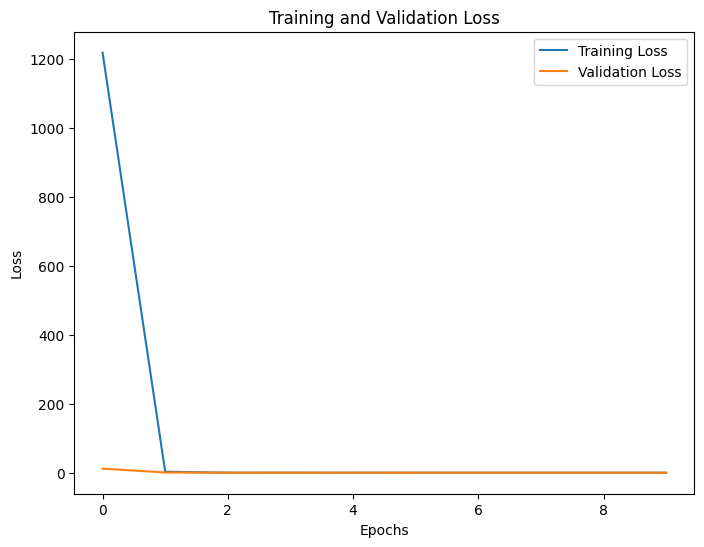

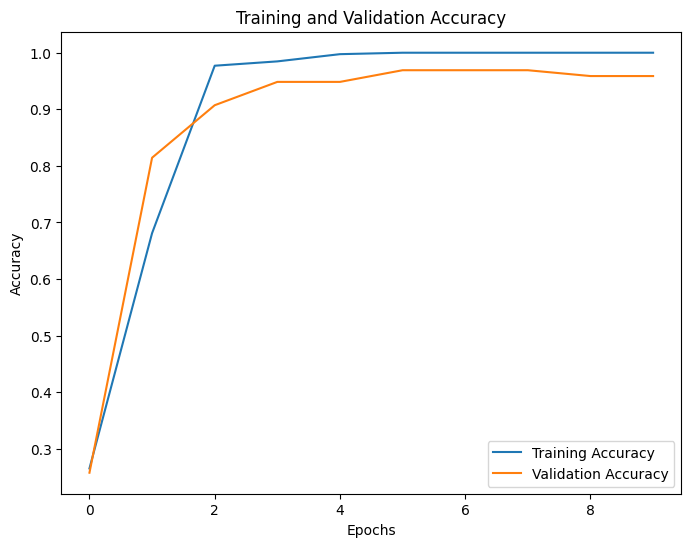

In [77]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [81]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = image.load_img(image_path, target_size=target_size)
    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)
    # Expand dimensions to create a batch (models expect batch input)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image (optional, depends on model training)
    img_array = img_array / 255.0
    return img_array


In [90]:
# Load and preprocess the image
image_path = rf"C:\Users\user\Downloads\test_A_chord_2.jpg"
processed_image = preprocess_image(image_path)

# Make a prediction
predictions = model.predict(processed_image)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=-1)[0]

# Access the class names
class_names = train_dataset.class_names

predicted_label = class_names[predicted_class]
print(f"Predicted label: {predicted_label}")

print(class_names)
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted label: A-Chord
['A-Chord', 'Bm-Chord', 'C-Chord', 'D-Chord', 'G-Chord']
Predicted class: 0
